# Testing a pre-trained model on our dataset

Model from: [cardiffnlp](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [11]:
from transformers import pipeline, AutoConfig, AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd 
import pprint as pp
import homemade_functions as hf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("Covid cases are increasing fast!")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'label': 'negative', 'score': 0.7235768437385559}]

### Load dataset
- No cleaning required as model will perform that for us - beyond adjusting our label columns

In [12]:
ds = load_dataset('yelp_review_full')
# df_train = pd.DataFrame(ds['train'].map(hf.remap_labels)) # Not currently using in this testing

df_test = pd.DataFrame(ds['test'].map(hf.remap_labels))
# display(df_train.head())

print(f"Minimum = {min(df_test['label'])} \nMaximum = {max(df_test['label'])}")
df_test.head()

Minimum = 0 
Maximum = 2


,label,text
0,0,I got 'new' tires from them and within two wee...
1,0,Don't waste your time. We had two different p...
2,0,All I can say is the worst! We were the only 2...
3,0,I have been to this restaurant twice and was d...
4,0,Food was NOT GOOD at all! My husband & I ate h...


 - had some issues with the model as some of the sentences were too long, we will truncate them down 

In [13]:
config = AutoConfig.from_pretrained(model_path)  
tokenizer = AutoTokenizer.from_pretrained(model_path)
max_position_embeddings = config.max_position_embeddings
max_length = min(tokenizer.model_max_length, max_position_embeddings)
print(f"Max Position Embeddings: {max_position_embeddings}")
print(f"Max Length: {max_length}")

Max Position Embeddings: 514
Max Length: 514


- Subtract 4 from that max_length to accomodate for special tokens used in tokenizer

In [14]:
max_length -= 4
max_length

510

### Run model

In [15]:
df = df_test.head(25000).copy() # scale down for initial tests and up to 25000 for the full run
tokenizer = sentiment_task.tokenizer
pred = df['text'].apply(lambda x: hf.trunc_analysis(model=sentiment_task, text=x, max_length = max_length))

In [16]:
pred[:5]

0    [{'label': 'negative', 'score': 0.777593195438...
1    [{'label': 'negative', 'score': 0.879970490932...
2    [{'label': 'negative', 'score': 0.899744629859...
3    [{'label': 'negative', 'score': 0.937634706497...
4    [{'label': 'negative', 'score': 0.934994280338...
Name: text, dtype: object

### Break down the scores into positive neutral and negative and add them back onto the dataframe

In [17]:
labels = []
for items in pred:
    for item in items:
        labels.append(item['label'])
labels[:5]

['negative', 'negative', 'negative', 'negative', 'negative']

In [18]:
print("min:", min(df['label']))
print("max:", max(df['label']))

min: 0
max: 2


 - lets convert those scores onto 0 for negative, 2 for neutral and 4 for positive to compare against the 0 to 4 scale of the label

In [19]:
df['preds'] = labels
pred_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df['numerical_preds'] = df['preds'].map(pred_mapping)
df.head()

,label,text,preds,numerical_preds
0,0,I got 'new' tires from them and within two wee...,negative,0
1,0,Don't waste your time. We had two different p...,negative,0
2,0,All I can say is the worst! We were the only 2...,negative,0
3,0,I have been to this restaurant twice and was d...,negative,0
4,0,Food was NOT GOOD at all! My husband & I ate h...,negative,0


### Lets graph some of the results

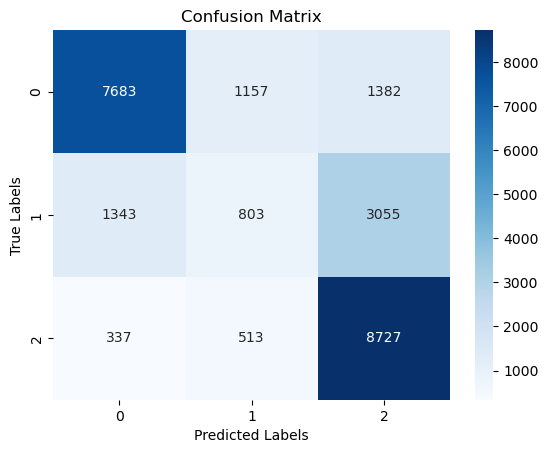

In [20]:

metrics, cm = hf.accuracy_scorer(df['label'], df['numerical_preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

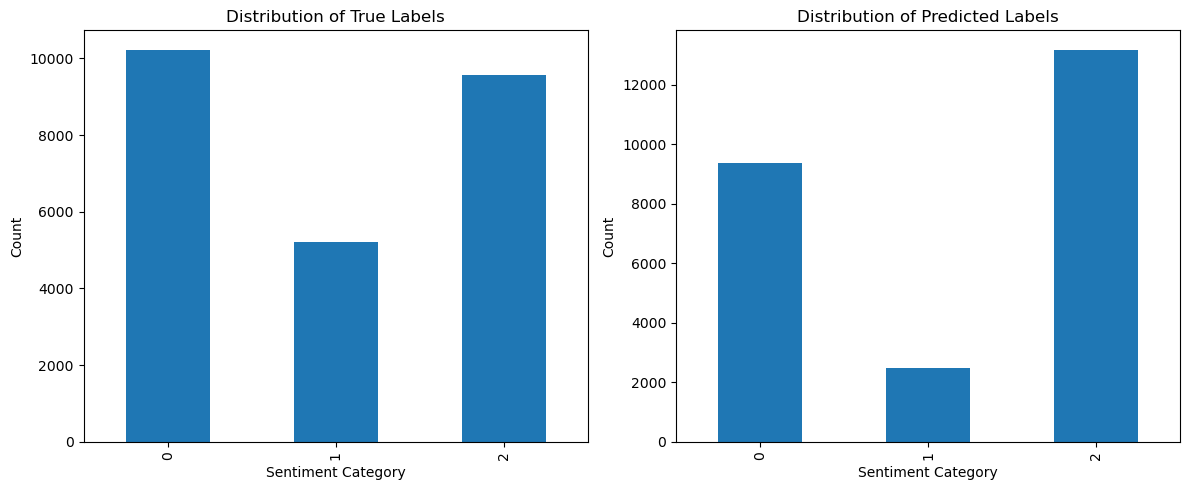

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of True Labels')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['numerical_preds'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [22]:
column_dict = { 
    "accuracy": [metrics[0]],
     "R Squared": [metrics[1]],
      "Mean Squared Error":[metrics[2]],
       "Precision": [metrics[3]],
        "Recall": [metrics[4]],
         "F1": [metrics[5]]
}
df_metrics = pd.DataFrame(column_dict)
df_metrics

,accuracy,R Squared,Mean Squared Error,Precision,Recall,F1
0,0.68852,0.34568,0.51776,0.657028,0.68852,0.658356


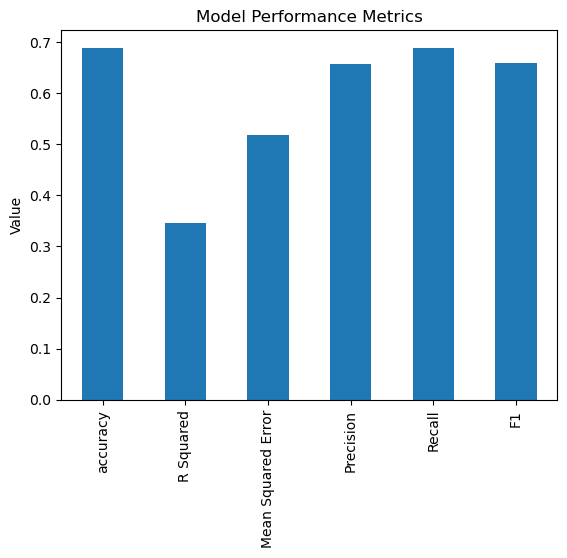

In [23]:
df_metrics.iloc[0].plot(kind='bar')
plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.show()



In [24]:


categories = df_metrics.columns.tolist()

fig = go.Figure()

for index, row in df_metrics.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[categories].tolist(),
        theta=categories,
        fill='toself',
        name=row['Model'] if 'Model' in df_metrics else f'Model {index+1}'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1] if 'R2' not in categories and 'MSE' not in categories else None
        )),
    showlegend=True
)

fig.show()